<a href="https://colab.research.google.com/github/YuvanBharathi13/USFB-Time-Series-Analysis/blob/main/USFB_timeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import numpy as np

## Data preperation

In [2]:
end_date = datetime.today()
print(end_date)

2025-11-02 06:40:12.055831


In [3]:
start_date = end_date - timedelta(days=2*365)
print(start_date)

2023-11-03 06:40:12.055831


In [4]:
df = yf.download('UJJIVANSFB.NS',start=start_date,end=end_date)

/tmp/ipython-input-771749527.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('UJJIVANSFB.NS',start=start_date,end=end_date)
[*********************100%***********************]  1 of 1 completed


In [16]:
df.head()

,UJJIVANSFB.NS
Date,
2023-11-03,52.069244
2023-11-06,56.033665
2023-11-07,56.130356
2023-11-08,55.163425
2023-11-09,55.115078


In [26]:
df.columns = ['Close']
df.head()

,Close
Date,
2023-11-03,52.069244
2023-11-06,56.033665
2023-11-07,56.130356
2023-11-08,55.163425
2023-11-09,55.115078


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 492 entries, 2023-11-03 to 2025-10-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   492 non-null    float64
dtypes: float64(1)
memory usage: 7.7 KB


In [28]:
df.shape

(492, 1)

In [29]:
usfb = df

Text(0, 0.5, 'Price')

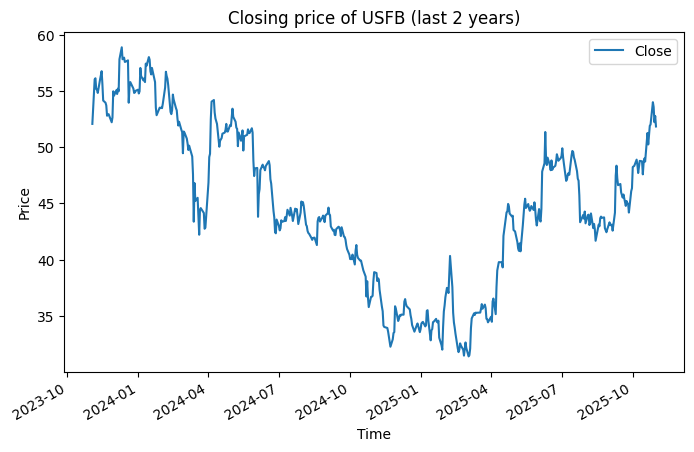

In [30]:
usfb.plot(figsize=(8,5))
plt.title("Closing price of USFB (last 2 years)")
plt.xlabel('Time')
plt.ylabel('Price')

In [31]:
usfb.shape

(492, 1)

In [32]:
time = usfb.index.to_numpy()
price = usfb['Close'].to_numpy()

## Splitting Data

In [33]:
train_size = int(0.8*len(usfb))
test_size = len(usfb)-train_size
train_size,test_size

(393, 99)

In [34]:
X_train = time[:train_size]
X_test = time[train_size:]
y_train = price[:train_size]
y_test = price[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((393,), (99,), (393,), (99,))

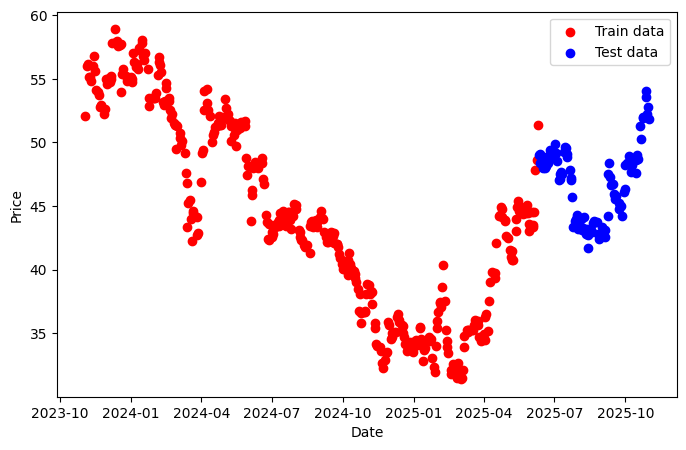

In [35]:
plt.figure(figsize=(8,5))
plt.scatter(X_train,y_train,color='red',label="Train data")
plt.scatter(X_test,y_test,color='blue',label='Test data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend();

## N-BEATS Algorithm

In [36]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int, theta_size: int, horizon: int, n_neurons: int,
               n_layers: int, **kwargs): # the **kwargs argument takes care of all of
               # the arguments for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [37]:
window_size = 7
horizon = 1

In [38]:
dummy_nbeats_block_layer = NBeatsBlock(input_size=window_size,
                                       theta_size=window_size+horizon, # backcast + forecast
                                       horizon=horizon,
                                       n_neurons=128,
                                       n_layers=4)

In [39]:
dummy_inputs = tf.expand_dims(tf.range(window_size) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [40]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.03277807 -0.736295    0.06213878  0.1848245  -0.04267824 -0.61994594
  0.6016378 ]
Forecast: -0.13685624301433563


In [42]:
usfb_nbeats = usfb.copy()
for i in range(window_size):
  usfb_nbeats[f"Day Close+{i+1}"] = usfb_nbeats["Close"].shift(periods=i+1)
usfb_nbeats.head()

,Close,Day Close+1,Day Close+2,Day Close+3,Day Close+4,Day Close+5,Day Close+6,Day Close+7
Date,,,,,,,,
2023-11-03,52.069244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-06,56.033665,52.069244,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-07,56.130356,56.033665,52.069244,NaN,NaN,NaN,NaN,NaN
2023-11-08,55.163425,56.130356,56.033665,52.069244,NaN,NaN,NaN,NaN
2023-11-09,55.115078,55.163425,56.130356,56.033665,52.069244,NaN,NaN,NaN


In [43]:
X = usfb_nbeats.dropna().drop("Close", axis=1)
y = usfb_nbeats.dropna()["Close"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(388, 388, 97, 97)

In [44]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 64 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [45]:
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = window_size * horizon # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + horizon

INPUT_SIZE, THETA_SIZE

(7, 8)

In [46]:
%%time
tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=horizon,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = tf.keras.layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=horizon,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)
  residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 200: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 384: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 484: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 1min 57s, sys: 6.83 s, total: 2min 4s
Wall time: 2min 43s


In [47]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.6470 - mae: 0.6470 - mse: 0.8209


[0.6535060405731201, 0.6535060405731201, 0.8346412777900696]

In [48]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [49]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

In [50]:
# Make predictions with N-BEATS model
preds = make_preds(model, test_dataset)
preds[:10]

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([47.763683, 48.665844, 48.41831 , 47.75776 , 48.94796 , 48.222527,
       48.045395, 48.477886, 48.88637 , 49.134457], dtype=float32)>

In [51]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.MeanAbsoluteError()(y_true, y_pred)
  mse = tf.keras.metrics.MeanSquaredError()(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.MeanAbsolutePercentageError()(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy()}

model_results = evaluate_preds(y_true=y_test,
                                 y_pred=preds)
model_results

{'mae': np.float32(0.65350604),
 'mse': np.float32(0.8346413),
 'rmse': np.float32(0.91358703),
 'mape': np.float32(1.394003)}

# Quantum part
Prepare the stock price dataset for encoding using qubits with the Qiskit framework.